# Mobile Robotics Project Report

## Table of Content:
* [Introduction](#Introduction)
* [General program flow](#General_program_flow)
* [Computer Vision](#Computer_vision )
* [Global navigation](#Global_navigation)
* [Filtering](#Filtering)
* [Local avoidance](#Local_avoidance)
* [Kidnapping](#Kidnapping)
* [Conclusion](#Conclusion)
  


## Project: Autonomous Navigation System for a Mobile Robot idk whatever u wanna name it

### Participants:
- **Alexis Limozin  (330717)**
- **Parth Aggarwal  (376263)**
- **Serge Elasmar   (326623)**
- **Quentin Angéloz (325935)**

---

# Introduction <a class="anchor" id="Introduction"></a>
The aim of our project is to manage the thymio's path to a target in an environment containing obstacles.
Our project uses a camera to create a map of the environment, taking obstacles into account. The thymio plans its path based on this map, and travels to where the obstacle is. If the environment changes and the robot detects an unexpected obstacle, the camera generates a new map that takes the new obstacle into account, and the thymio corrects its route.
## Assumptions and environment description
- The environment is a plane.
- The ground is only one color.
- Obstacles color is black
- The goal color is green
- Operate the camera, obstacles and robot in a controlled environment
- The Thymio is identified by two unique pieces of red tape

## Environment Visual

## Implementation

## General program flow <a class="anchor" id="General_program_flow"></a>
Note: to make it robust to kidnapping, I'll set a state in the FSM that activates when the two ground sensors no longer detect anything. When it's in this state, the robot just waits to be repositioned; when it's repositioned, the camera identifies the robot's location again and we continue as normal.
The way I see it : 
## Transitions 
## WILL CHANGE IN DUE TIME

* State 0 : Robot stopped, camera acquisition
  * Event A: Map acquired -&gt; State 1
* State 1 : Robot goes to target
  * Event B: Target reached  -&gt; State 2
  * Event C: Robot is kidnapped (ground sensors see nothing) -&gt; State 3
  * Event D: Obstacle detected  -&gt; State 4
* State 2 : Program is over
* State 3 : Robot kidnapped
  * Event D : back on ground -&gt; State 0
* State 4 : Avoids obstacles
  * Event F : Need a new map -&gt; State 0
This can be visualised with the graph below

In [11]:
%pip install matplotlib networkx

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


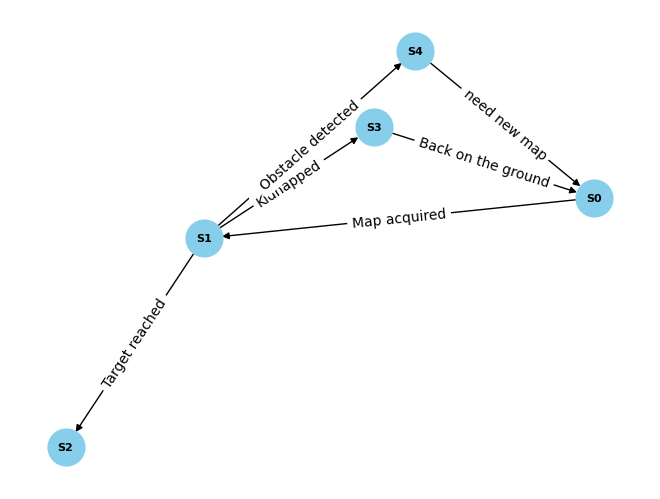

In [13]:
import matplotlib.pyplot as plt

import networkx as nx

# Define the FSM
states = ['S0', 'S1', 'S2', 'S3', 'S4']
transitions = [('S0', 'S1', 'Map acquired'), ('S1', 'S2', 'Target reached'),
               ('S1', 'S3', 'Kidnapped'), ('S3', 'S0', 'Back on the ground'), ('S1', 'S4', 'Obstacle detected'), ('S4', 'S0', 'need new map')]

# Create directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for state in states:
    G.add_node(state)

for transition in transitions:
    G.add_edge(transition[0], transition[1], label=transition[2])

# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_size=8)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Display the plot
plt.show()


# Computer vision <a class="anchor" id="Computer_vision"></a>

In [30]:
from vision.ComputerVision import Vision
# section to load all libraries required above explanations 

ModuleNotFoundError: No module named 'shapely'

The vision aspect of our project is designed to navigate the robot through an environment with obstacles utlising a stationary camera. Our approach follows the following steps:

1. Detecting and locating the robot and its orientation 
2. Identifying obstacles and their boundaries 
3. Determining a goal position 
4. Computing the shortest path for the robot to reach the goal while avoiding obstacles. 

### Libraries used to aid Vision 
- `OpenCV`: Used for image detection, contour detection, geometric transformations, utilised to process captured frames and purpose the visual input to achieve the goal 
- `NumPy`: Utilised for all numerical operations
- `Pyvisgraph`: Utilised for computing optimal robot paths based on all calculations 
- `Shapely`: Utilised for manipulating planar geometric objects (to create union between obstacles that are close together)

### 1. Robot Detection and Localisation 

This is conducted throught the `find_robot()` function which operates solely on the defined vision class (as such this is the sole input). It accomplishes this through advanced image processing techniques, focusing on color filtering and contour detection, followed by a detailed analysis of the detected shapes.

Firstly, through *colour filitering* the image is converted from its original BGR format to RGB. We then apply a colour filter to isolate the colour red, which is present on the thymio robot (as per our assumptions). This is achieved through definind a specific range in the RBG colour space that corresponds ot the red colour, resulting in a binary mask whre the red areas are highlighted. 

Then we undergo *contour detection* by using `cv2.findContours()` to detect the exact shape and structure of the labelling on the thymio. These contours, representing the boundaries of the red shapes are critical for the accurate determination of the robot's position. A specific range of contour areas are checked, to denoise the result and only get the two markers contours and positions. The contour area feature is also used to differentiate between the nose marker and the tail marker on the robot.

This structure allows us to *calculate the centroids* by utilising the moments of the two contours. `cv2.moments()` allows for extraction of specific spatial moments required to compute the coordinates of the centroid which are calculated using the following formulae:

$$C_x = \frac{M_{10}}{M_{00}},\; C_y = \frac{M_{01}}{M_{00}}$$ 

The calculation of this centroid helps provide 5 critical pieces of information:
1. **Central reference point**: Concise and accurate position of robot in environment, calculated from the average of the two markers position.
2. **Orientation of robot**: The direction in which the robot is facing is inferred from the arctangent of the two centroids locations. 
3. **Scale Calibration**: By knowing the physical distance between the two marker centroids on the robot and comparing it with the pixel distance between their centroids in the image, you can establish a scale factor, providing the scale for all future calculations.
4. **Movement Analysis**: The centroid can be tracked in sequential frames, thus, changes in the centroid's location over time provide information about the speed and direction of the robot's movement. 
5. **Path Planning Input**: The positional data derived from the centroids assist significantly in the path planning process, to be elaborated later in the report. 


In [31]:
## Insert Image of robot being detected alongside supporting evidence for the above- such as orientation and Movement


### 2. Obstacle Detection
This is achieved through the `find_graph()` function which again takes in the vision class as its sole input. Obstacle detection is achieved through Greyscale conversion, thresholding, contour approximation which blends together to contribute to larger objective of creating a map for the robot to follow. 

The first step is *Greyscale Conversion* which significantly simplifies the process of identifying obstacles through `cv2.cvtColor()`. In greyscale, the intensity of each pixel represents different shades of grey, disregarding colour which is not needed to identify black (all obstacles are black as stated in assumptions). Once the image is rendered, *Thresholding* takes place which outputs an image where the black obstacles are distinctly visible against the background. 

In a similar process to above, the contours are detected but for obstacles, they are further simplifed in the process of *Contour Approximation* utilising `cv2.approxPolyDP()` to create the shape of the obstacles. This returns the object (obstacle) defined as a set of corners. This is done in order to balance between retaining the essential shape while reducing computational complexity. This serves to keep the algorithm efficient while maintaining accuracy. 

Finally, the boundaries of the actual obstacles and the robot have been defined. But in order to ensure that the path planning function is able to create a safe path through the obstacles, we conduct a *Vector Calculation* for Obstacles. 
This is done in `find_farthest_vector()` which takes in the set of corners for each of the obstacles, with the end goal being to create a safety net around obstacles to avoid collision. For each corner, this function calculates the sum of two vectors made from a first vector [previous_corner, corner] and [next_corner, coner] and normalizes it. We then get the vector pointing outward relative to an obstacle for each corner of an obstacle.

Then we can set the corners of each obstacles at a certain distance (determined using the scale factor obtained from the `find_robot()` function) along this vector from the obstacle. This helps create a buffer around the obstacles hence preventing the robot's path from getting too close to an obstacle. This also allows for the accomodation of any errors in measurement or movement. 

In [ ]:
IMAGE of both find graph output and find farthest vector output

### 3. Goal Identification
The function `find_goal()` is utilised to identify the green marker which is placed at the end objective (as per assumptions). This function operates in the vision class and returns the centroid position of the goal. As part of the Vision class, this method ensures that the goal's location is consistently updated and integrated with the robot's navigation system.

Similar to the Robot localisation, this function operates by first applying colour filtering to isolate green (as per assumptions about the goal colour). This mask is then applied to the image and contours are attached to accurately grasp the goal. Following the same process as the Robot Localisation above, centroids are calculated and the end goal of the robot is saved into the vision class, making it accessible for future calculations.  

In [ ]:
IMAGE FOR GREEN mask

### 4. Path Planning
The first step is to construct a visibility graph utilising `pyvisgraph` and general graph theory to visualise the corners of obstacles, robot's current position, and the goal. This is built in `find_graph` which goes through *Greyscale and Thresholding*, *Contour Detection and Polygon Approximation* and then *Vector Calculation for Safety Margins*. 

Once this processing is done, the space between obstacles is checked to ensure enough space for a thymio to travel through. For that, an algorithm checks if each polygon formed from the nodes around an obstacle intersect with other polygons. If two polygons are intersecting, they are combined into a bigger polygon, which the thymio will go around. This is done with the help of functions from the `shapely` library.

Finally, the visibility graph is built with the help of the `pyvisgraph` library, by feeding it a list of non-intersecting polygons coordinates. This will determine which all the neighbours of each node and store them in an object.

The `find_shortest_path()` function in the Vision class plays a pivotal role in the robot's navigation system. Taking in the above map where there are the integrated outputs from the robot detection, obstacle detection, and goal identification processes to compute the optimal path for the robot to reach its goal using Djikstra's algorithm. 

In [ ]:
INSERT Visuals

# Global navigation <a class="anchor" id="Global_navigation"></a>

# Filtering <a class="anchor" id="Filtering"></a> 

The implementation of a Kalman filter is necessary to obtain smooth performance. It allows our robot to obtain a more precise estimate of its position. Furthermore, if at some point the vision loses the robot (or the robot is hidden), the position estimate will still get updated thanks to the motion model. However, our uncertainty on position will increase until a new camera measurement is given.

### The state space model

A state space representation of our model can be given as follows:
\begin{equation}
        x_t = \begin{bmatrix}
        1&0&0\\
        0&1&0\\
        0&0&1\\
        \end{bmatrix} x_{t-1} + \begin{bmatrix}
                                \frac{R}{2}cos(x_{3,t-1})\Delta t & \frac{R}{2}cos(x_{3,t-1})\Delta t\\
                                \frac{R}{2}sin(x_{3,t-1})\Delta t & \frac{R}{2}sin(x_{3,t-1})\Delta t\\
                                -\frac{R}{d}\Delta t & \frac{R}{d}\Delta t\\
                                \end{bmatrix} u
\end{equation}

\begin{equation}
        y_t = \begin{bmatrix}
        1&0&0\\
        0&1&0\\
        0&0&1\\
        \end{bmatrix} x_t
\end{equation}

with R the radius of the wheels, d the wheelbase of the thymio and:

\begin{equation}
        x_t = \begin{bmatrix}
                x_{1,t}\\
                x_{2,t}\\
                x_{3,t}\\
                \end{bmatrix} = \begin{bmatrix}
                                x_t\\
                                y_t\\
                                \theta_t\\
                                \end{bmatrix} \text{and } u = \begin{bmatrix}
                                                                \omega_r\\
                                                                \omega_l\\
                                                                \end{bmatrix}
        \end{equation}

### Filter choice and parameters
We can see in the model above that our model has no non-linearities ($x_{3,t-1}$ is already known at time $t$ so $cos(x_{3,t-1})$ and $sin(x_{3,t-1})$ are scalars). We can therefore use a linear Kalman filter.

In [ ]:



dt calculated using average by running main

changer le - dans z quand ce ser aregler dans vision

# Local avoidance <a class="anchor" id="Local_avoidance"></a>

# Kidnapping <a class="anchor" id="Kidnapping"></a>

# Conclusion <a class="anchor" id="Conclusion"></a>